In [1]:
import pandas as pd
import numpy as np
import influxdb_client
import matplotlib.pyplot as plt

from influxdb_client.client.write_api import SYNCHRONOUS

org = "fh_soest"
url = "https://eu-central-1-1.aws.cloud2.influxdata.com"
token = "Bt4r9yYLtH7gitVgnwgULJ47UFmymn18378SsnJMdRXFVz_S14WmPI5JYU-CV4MtpzThGFVhEUJ6htpLX0M43w=="
bucket = "fh_bucket"
write_client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

write_api = write_client.write_api(write_options=SYNCHRONOUS)
query_api = write_client.query_api()

In [2]:
# SIMPLE QUERY
query1 = """from(bucket: "fh_bucket")
            |> range(start: 2023-12-18T10:00:00Z, stop: now())
            |> filter(fn: (r) => r["_measurement"] == "Experiment")
            |> filter(fn: (r) => r["Device_ID"] == "0013A20041BDFD8D")
            |> filter(fn: (r) => r["Location"] == "Soest")
            |> filter(fn: (r) => r["_field"] == "Light")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
         """

query2 = """from(bucket: "fh_bucket")
            |> range(start: 2023-12-18T10:00:00Z, stop: now())
            |> filter(fn: (r) => r["_measurement"] == "Experiment")
            |> filter(fn: (r) => r["Device_ID"] == "0013A20041BDFD8D")
            |> filter(fn: (r) => r["Location"] == "Soest")
            |> filter(fn: (r) => r["_field"] == "Temperature")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
         """

query3 = """from(bucket: "fh_bucket")
            |> range(start: 2023-12-18T10:00:00Z, stop: now())
            |> filter(fn: (r) => r["_measurement"] == "Experiment")
            |> filter(fn: (r) => r["Device_ID"] == "0013A20041BDFD8D")
            |> filter(fn: (r) => r["Location"] == "Soest")
            |> filter(fn: (r) => r["_field"] == "Altitude")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
         """

query4 = """from(bucket: "fh_bucket")
            |> range(start: 2023-12-18T10:00:00Z, stop: now())
            |> filter(fn: (r) => r["_measurement"] == "Experiment")
            |> filter(fn: (r) => r["Device_ID"] == "0013A20041BDFD8D")
            |> filter(fn: (r) => r["Location"] == "Soest")
            |> filter(fn: (r) => r["_field"] == "Pressure")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
         """

query5 = """from(bucket: "fh_bucket")
            |> range(start: 2023-12-18T10:00:00Z, stop: now())
            |> filter(fn: (r) => r["_measurement"] == "Experiment")
            |> filter(fn: (r) => r["Device_ID"] == "0013A20041BDFD8D")
            |> filter(fn: (r) => r["Location"] == "Soest")
            |> filter(fn: (r) => r["_field"] == "Battery")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
         """

In [3]:
# Query: using Pandas DataFrame
df1 = query_api.query_data_frame(query1)
df2 = query_api.query_data_frame(query2)
df3 = query_api.query_data_frame(query3)
df4 = query_api.query_data_frame(query4)
df5 = query_api.query_data_frame(query5)

In [4]:
df1 = df1[["_time", "Device_ID", "Location", "_measurement", "Light"]]
df2 = df2[["_time", "Device_ID", "Location", "_measurement", "Temperature"]]
df3 = df3[["_time", "Device_ID", "Location", "_measurement", "Altitude"]]
df4 = df4[["_time", "Device_ID", "Location", "_measurement", "Pressure"]]
df5 = df5[["_time", "Device_ID", "Location", "_measurement", "Battery"]]

In [5]:
df5.head()

,_time,Device_ID,Location,_measurement,Battery
0,2024-01-23 14:38:21.218773+00:00,0013A20041BDFD8D,Soest,Experiment,98.3
1,2024-01-23 14:38:31.101315+00:00,0013A20041BDFD8D,Soest,Experiment,98.3
2,2024-01-23 14:38:45.460833+00:00,0013A20041BDFD8D,Soest,Experiment,98.3
3,2024-01-23 14:39:01.660385+00:00,0013A20041BDFD8D,Soest,Experiment,98.3
4,2024-01-23 14:39:15.609948+00:00,0013A20041BDFD8D,Soest,Experiment,98.3


In [6]:
# Merge dataframes on common columns
dfs = [df1, df2, df3, df4, df5]

# Starting with the first dataframe
merged_df = dfs[0]

# Iterating over the rest of the dataframes and merging
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['_time', 'Device_ID', 'Location', '_measurement'], how='inner')

# Rename the columns
result_df = merged_df.rename(columns={'_Time': 'Time', '_measurement': 'Measurement'})

In [7]:
result_df.head()

,_time,Device_ID,Location,Measurement,Light,Temperature,Altitude,Pressure,Battery
0,2024-01-23 14:38:21.218773+00:00,0013A20041BDFD8D,Soest,Experiment,192.0,18.54,9.36,101212.67,98.3
1,2024-01-23 14:38:31.101315+00:00,0013A20041BDFD8D,Soest,Experiment,192.0,18.54,8.76,101219.78,98.3
2,2024-01-23 14:38:45.460833+00:00,0013A20041BDFD8D,Soest,Experiment,192.0,18.55,8.52,101222.76,98.3
3,2024-01-23 14:39:01.660385+00:00,0013A20041BDFD8D,Soest,Experiment,192.0,18.57,8.78,101219.55,98.3
4,2024-01-23 14:39:15.609948+00:00,0013A20041BDFD8D,Soest,Experiment,209.0,18.59,8.51,101222.81,98.3


In [16]:
# Convert the 'time' column to datetime format
result_df['_time'] = pd.to_datetime(result_df['_time'])

# Filter rows where 'time' is on or after 29 January 2024
filtered_df = result_df[result_df['_time'] >= '2024-01-29']

# Convert datetime values to timezone-naive format
filtered_df['_time'] = filtered_df['_time'].dt.tz_localize(None)

C:\Users\bryan\AppData\Local\Temp\ipykernel_13292\2490959831.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['_time'] = filtered_df['_time'].dt.tz_localize(None)


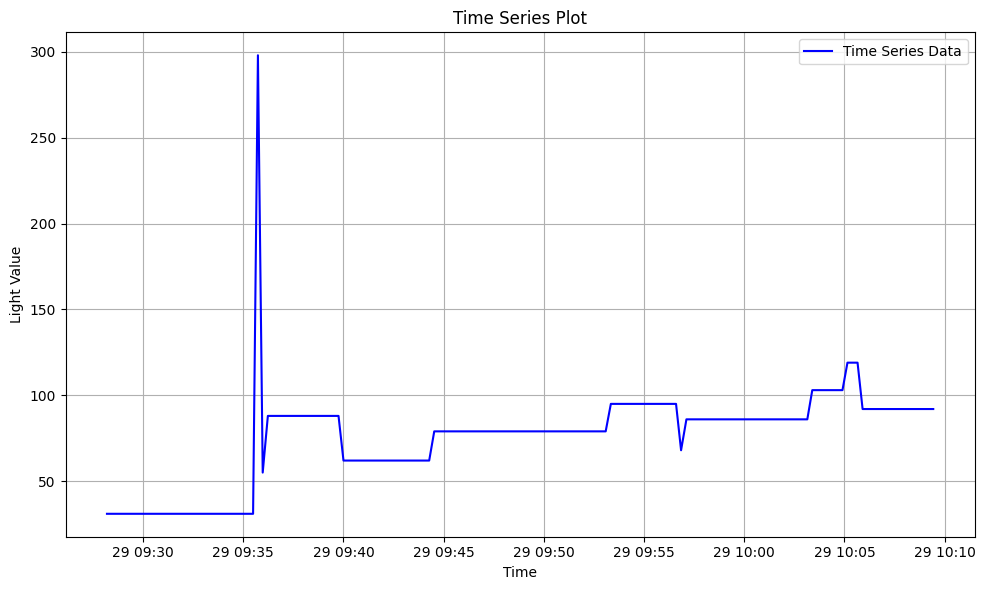

In [17]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['_time'], filtered_df['Light'], label='Time Series Data', color='blue')

plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Light Value')
plt.title('Time Series Plot')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
filtered_df

,_time,Device_ID,Location,Measurement,Light,Temperature,Altitude,Pressure,Battery
87,2024-01-29 09:28:11.938998,0013A20041BDFD8D,Soest,Experiment,31.0,17.92,-9.90,101444.03,-0.0
88,2024-01-29 09:28:26.522847,0013A20041BDFD8D,Soest,Experiment,31.0,17.92,-9.98,101444.92,-0.0
89,2024-01-29 09:28:41.457502,0013A20041BDFD8D,Soest,Experiment,31.0,17.93,-9.96,101444.65,-0.0
90,2024-01-29 09:28:56.507864,0013A20041BDFD8D,Soest,Experiment,31.0,17.93,-9.89,101443.82,-0.0
91,2024-01-29 09:29:11.118517,0013A20041BDFD8D,Soest,Experiment,31.0,17.92,-9.83,101443.09,-0.0
...,...,...,...,...,...,...,...,...,...
247,2024-01-29 10:08:26.133316,0013A20041BDFD8D,Soest,Experiment,92.0,18.22,-13.96,101492.78,98.3
248,2024-01-29 10:08:40.694581,0013A20041BDFD8D,Soest,Experiment,92.0,18.23,-13.91,101492.17,98.3
249,2024-01-29 10:08:54.811566,0013A20041BDFD8D,Soest,Experiment,92.0,18.23,-13.96,101492.80,98.3
250,2024-01-29 10:09:11.563557,0013A20041BDFD8D,Soest,Experiment,92.0,18.23,-13.89,101491.91,98.3


In [19]:
# Save the filtered DataFrame to an Excel file
filtered_df.to_excel('filtered_data.xlsx', index=True)